In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load image files

In [2]:
imgfiles = os.listdir('human_image')
#
ori_imgdir = 'human_image'
msk_imgdir = 'human_image_masked'
#
ori_imgfiles = []
msk_imgfiles = []
for i, file in enumerate(imgfiles):
    ori_imgfiles.append(os.path.join(ori_imgdir, file))
    msk_imgfiles.append(os.path.join(msk_imgdir, file))
del imgfiles

### Load data from an image file

In [3]:
def get_data(index):
    img = plt.imread(ori_imgfiles[index])
    msk = plt.imread(msk_imgfiles[index])
    return img, msk

#### visualize data

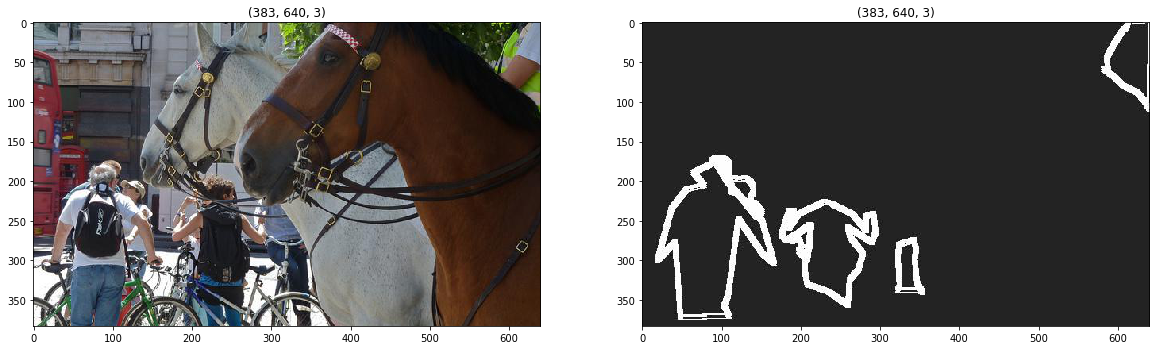

In [10]:
r = np.random.randint(0, len(ori_imgfiles))
img, msk = get_data(r)
# show it to me
plt.figure(figsize = (20, 20))
plt.subplot(121); plt.imshow(img); plt.title(img.shape)
plt.subplot(122); plt.imshow(msk[:, :, 0], cmap = 'gray'); plt.title(msk.shape)
plt.show()

## Split dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
rs = 41
xTrain_files, xRest_files, yTrain_files, yRest_files = train_test_split(ori_imgfiles, msk_imgfiles,
                                                                        test_size = 0.3, random_state = rs)
xValid_files, xTest_files, yValid_files, yTest_files = train_test_split(xRest_files, yRest_files,
                                                                        train_size = 0.3, random_state = rs)
print('train: {}'.format(len(xTrain_files)))
print('valid: {}'.format(len(xValid_files)))
print('test: {}'.format(len(xTest_files)))

train: 31621
valid: 4065
test: 9488


## Image generator and input pipeline

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

In [14]:
def load_inputs(xfiles, yfiles, height, width):
    # Warning, must binarize after data augmentation
    n = len(xfiles)
    x_data = np.zeros((n, height, width, 3))
    y_data = np.zeros((n, height, width))
    
    for i in range(n):
        x_data[i] = np.array(load_img(xfiles[i],
                                      color_mode = 'rgb',
                                      target_size = (height, width),
                                      interpolation = 'nearest'))
        
        y_data[i] = np.array(load_img(yfiles[i],
                                      color_mode = 'grayscale',
                                      target_size = (height, width),
                                      interpolation = 'nearest'))
    return x_data, y_data

def rescale_inputs(x, y):
    t = 0.4
    x_binary = x.copy()/np.max(x)
    y_binary = y.copy()/np.max(y)
    y_binary[y_binary < t] = 0.
    y_binary[y_binary >= t] = 1.
    return x_binary, y_binary

In [15]:
x, y = load_inputs(xTrain_files[0:20], yTrain_files[0:20], height = 256, width = 256)
xb, yb = rescale_inputs(x, y)

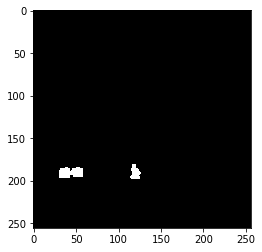

In [16]:
plt.imshow(yb[17], cmap = 'gray')

## Build model

In [17]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model, Sequential

In [18]:
def u_net():
    input_layer = layers.Input(shape = (256, 256, 3))
    # downsampling
    c1 = layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(input_layer)
    b1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPool2D(2, 2)(b1)

    c2 = layers.Conv2D(32, 3, 1, 'same', activation = 'relu')(p1)
    b2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPool2D(2, 2)(b2)

    c3 = layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(p2)
    b3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPool2D(2, 2)(b3)

    c4 = layers.Conv2D(64, 3, 1, 'same', activation = 'relu')(p3)
    b4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPool2D(2, 2)(b4)

    c5 = layers.Conv2D(128, 3, 1, 'same', activation = 'relu')(p4)
    b5 = layers.BatchNormalization()(c5)
    p5 = layers.MaxPool2D(2, 2)(b5)

    # upsampling
    dc0 = layers.Conv2DTranspose(256, 3, 1, 'same', activation = 'relu')(p5)
    db0 = layers.BatchNormalization()(dc0)
    cn0 = layers.concatenate([p5, db0])

    dc1 = layers.Conv2DTranspose(128, 3, 1, padding = 'same', activation = 'relu')(cn0)
    db1 = layers.BatchNormalization()(dc1)
    up1 = layers.UpSampling2D(2)(db1)
    cn1 = layers.concatenate([p4, up1])

    dc2 = layers.Conv2DTranspose(64, 3, 1, padding = 'same', activation = 'relu')(cn1)
    db2 = layers.BatchNormalization()(dc2)
    up2 = layers.UpSampling2D(2)(db2)
    cn2 = layers.concatenate([p3, up2])

    dc3 = layers.Conv2DTranspose(64, 3, 1, padding = 'same', activation = 'relu')(cn2)
    db3 = layers.BatchNormalization()(dc3)
    up3 = layers.UpSampling2D(2)(db3)
    cn3 = layers.concatenate([p2, up3])

    dc4 = layers.Conv2DTranspose(32, 3, 1, padding = 'same', activation = 'relu')(cn3)
    db4 = layers.BatchNormalization()(dc4)
    up4 = layers.UpSampling2D(2)(db4)
    cn4 = layers.concatenate([p1, up4])

    dc5 = layers.Conv2DTranspose(32, 3, 1, padding = 'same', activation = 'relu')(cn4)
    db5 = layers.BatchNormalization()(dc5)
    up5 = layers.UpSampling2D(2)(db5)

    output_layer = layers.Conv2DTranspose(1, 1, 1, padding = 'same', activation = 'sigmoid')(up5)

    # Model
    model = Model(inputs = input_layer, outputs = output_layer)
    return model

## Train Model

In [19]:
import random

In [20]:
model = u_net()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
loss = []
acc  = []

In [29]:
batch_size = 256
iterations = np.ceil(len(xTrain_files)/batch_size).astype(int)
for i in range(20, 21):
        
    i_1 = i*batch_size
    i_2 = (i + 1)*batch_size
        
#     w = random.choice([256, 512])
#     h = random.choice([256, 512])
        
    x, y = load_inputs(xTrain_files[i_1:i_2], yTrain_files[i_1:i_2], height = 256, width = 256)
    y = np.expand_dims(y, -1)
    x, y = rescale_inputs(x, y)
        
    trn_data = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(256).batch(32)
        
    h = model.fit(trn_data, epochs = 2000, verbose = 1)
    
    loss.append(np.mean(h.history['loss']))
    acc.append(np.mean(h.history['accuracy']))
    
    print('Iter: {}, loss: {:.4f}, acc: {:.3f}'.format(i, loss[-1], acc[-1]))

In [34]:
i = 20

i_1 = i*batch_size
i_2 = (i + 1)*batch_size
        
x, y = load_inputs(xTrain_files[i_1:i_2], yTrain_files[i_1:i_2], height = 256, width = 256)
y = np.expand_dims(y, -1)
x, y = rescale_inputs(x, y)

In [35]:
pred = model.predict(x)
pred = np.squeeze(pred)

(-0.5, 255.5, 255.5, -0.5)

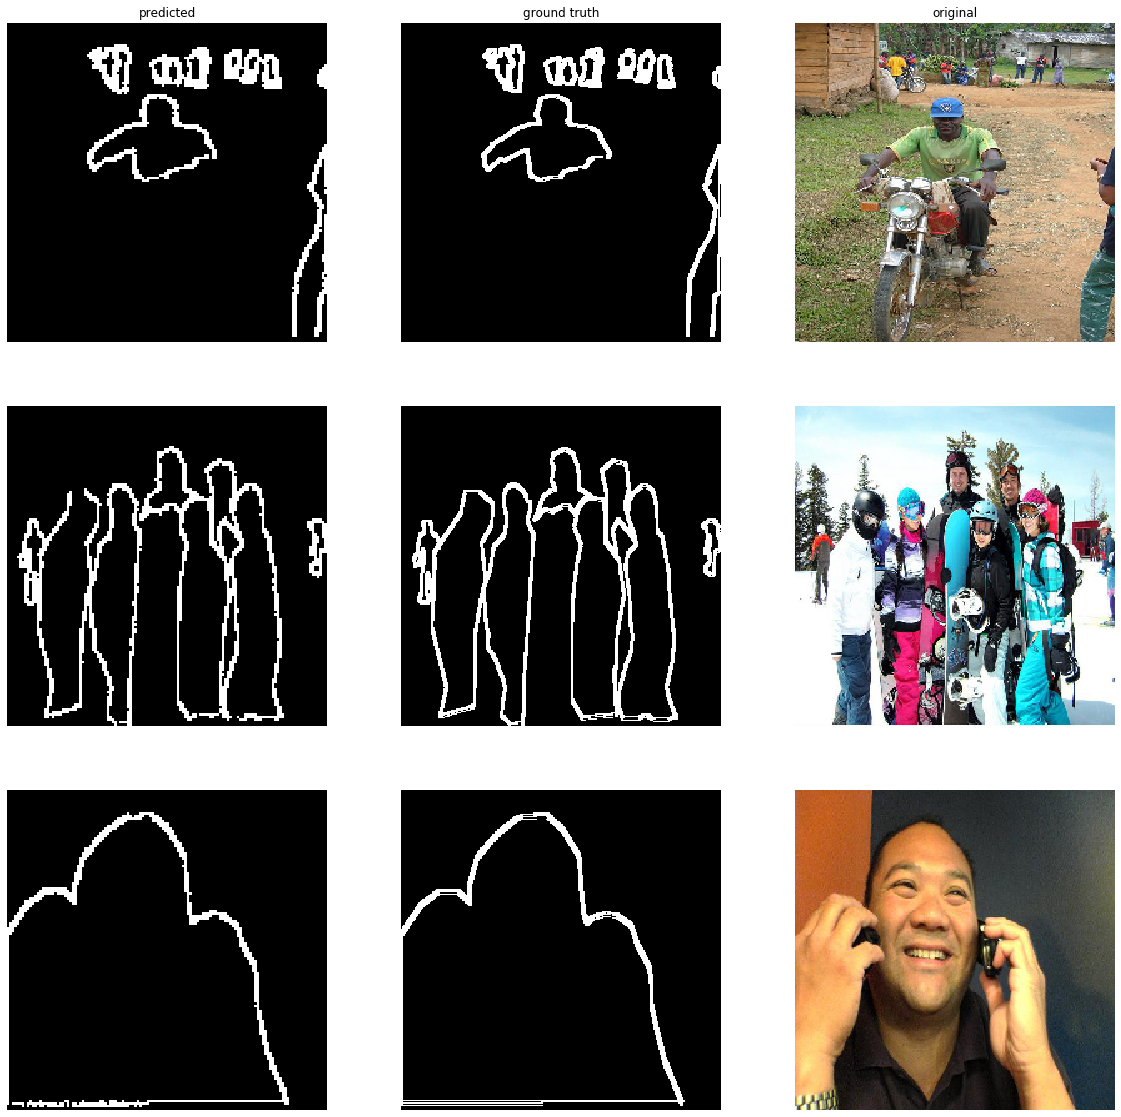

In [64]:
t = [0.5] * 3
a = np.random.randint(0, 256)
b = np.random.randint(0, 256)
c = np.random.randint(0, 256)
index = [a, b, c]
# show
plt.figure(figsize = (20, 20))
pt = pred[index].copy()/np.max(pred[index])
pt[0][pt[0] < t[0]] = 0.; pt[0][pt[0] >= t[0]] = 1.
pt[1][pt[1] < t[1]] = 0.; pt[1][pt[1] >= t[1]] = 1.
pt[2][pt[2] < t[2]] = 0.; pt[2][pt[2] >= t[2]] = 1.
plt.subplot(331); plt.imshow(pt[0], cmap = 'gray'); plt.axis('off'); plt.title('predicted')
plt.subplot(332); plt.imshow(y[index[0]].squeeze(), cmap = 'gray'); plt.axis('off'); plt.title('ground truth')
plt.subplot(333); plt.imshow(x[index[0]]); plt.axis('off'); plt.title('original')

plt.subplot(334); plt.imshow(pt[1], cmap = 'gray'); plt.axis('off')
plt.subplot(335); plt.imshow(y[index[1]].squeeze(), cmap = 'gray'); plt.axis('off')
plt.subplot(336); plt.imshow(x[index[1]]); plt.axis('off')

plt.subplot(337); plt.imshow(pt[2], cmap = 'gray'); plt.axis('off')
plt.subplot(338); plt.imshow(y[index[2]].squeeze(), cmap = 'gray'); plt.axis('off')
plt.subplot(339); plt.imshow(x[index[2]]); plt.axis('off')

In [45]:
model.save('u_net')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: u_net\assets
